
## 1. Prosta regresja liniowa

### Wczytanie danych

Pobierz dane `bikes.csv` do swojego katalogu roboczego, a następnie wczytaj je. Użyj argumentu `col_types` żeby ustawić typ poszczególnych kolumn: `D` - data, `f` - faktor, `d` - double.

In [1]:
library(tidyverse)
library(gridExtra)
library(corrplot)
library(repr)
options(jupyter.rich_display=FALSE,
        repr.plot.width=15,
        repr.plot.height=8)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


corrplot 0.95 loaded



In [2]:
rowery <- read_csv("data/bikes.csv", col_types = "Dffffddddd")

Wyświetl podgląd danych za pomocą funkcji `glimpse()`

In [3]:
glimpse(rowery)

Rows: 731
Columns: 10
$ date        <date> 2011-01-01, 2011-01-02, 2011-01-03, 2011-01-04, 2011-01-0…
$ season      <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ holiday     <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0…
$ weekday     <fct> 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4…
$ weather     <fct> 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2…
$ temperature <dbl> 46.71653, 48.35024, 34.21239, 34.52000, 36.80056, 34.88784…
$ realfeel    <dbl> 46.39865, 45.22419, 25.70131, 28.40009, 30.43728, 30.90523…
$ humidity    <dbl> 0.805833, 0.696087, 0.437273, 0.590435, 0.436957, 0.518261…
$ windspeed   <dbl> 6.679665, 10.347140, 10.337565, 6.673420, 7.780994, 3.7287…
$ rentals     <dbl> 985, 801, 1349, 1562, 1600, 1606, 1510, 959, 822, 1321, 12…


Wyświetl i przeanalizuj statystyki opisowe danych `rowery`.

In [4]:
summary(rowery)

      date            season  holiday weekday weather  temperature   
 Min.   :2011-01-01   1:181   0:710   6:105   2:247   Min.   :22.60  
 1st Qu.:2011-07-02   2:184   1: 21   0:105   1:463   1st Qu.:46.12  
 Median :2012-01-01   3:188           1:105   3: 21   Median :59.76  
 Mean   :2012-01-01   4:178           2:104           Mean   :59.51  
 3rd Qu.:2012-07-01                   3:104           3rd Qu.:73.05  
 Max.   :2012-12-31                   4:104           Max.   :90.50  
                                      5:104                          
    realfeel         humidity        windspeed          rentals    
 Min.   : 12.59   Min.   :0.0000   Min.   : 0.9322   Min.   :  22  
 1st Qu.: 43.34   1st Qu.:0.5200   1st Qu.: 5.6182   1st Qu.:3152  
 Median : 61.02   Median :0.6267   Median : 7.5343   Median :4548  
 Mean   : 59.55   Mean   :0.6279   Mean   : 7.9303   Mean   :4504  
 3rd Qu.: 75.50   3rd Qu.:0.7302   3rd Qu.: 9.7092   3rd Qu.:5956  
 Max.   :103.10   Max.   :0.9725

Narysuj wykresy punktowe porównujące `rentals` (liczbę wypożyczonych rowerów) do trzech innych zmiennych (`humidity`, `windspeed` oraz `temperature`). Co możesz powiedzieć na temat zależności między zmienną `rentals` a pozostałymi wybranymi zmiennymi na podstawie samych wykresów?

In [5]:
head(rowery)

  date       season holiday weekday weather temperature realfeel humidity
1 2011-01-01 1      0       6       2       46.71653    46.39865 0.805833
2 2011-01-02 1      0       0       2       48.35024    45.22419 0.696087
3 2011-01-03 1      0       1       1       34.21239    25.70131 0.437273
4 2011-01-04 1      0       2       1       34.52000    28.40009 0.590435
5 2011-01-05 1      0       3       1       36.80056    30.43728 0.436957
6 2011-01-06 1      0       4       1       34.88784    30.90523 0.518261
  windspeed rentals
1  6.679665  985   
2 10.347140  801   
3 10.337565 1349   
4  6.673420 1562   
5  7.780994 1600   
6  3.728766 1606   

In [6]:
tail(rowery)

  date       season holiday weekday weather temperature realfeel humidity
1 2012-12-26 1      0       3       3       38.18597    29.37556 0.823333
2 2012-12-27 1      0       4       2       39.10253    30.12507 0.652917
3 2012-12-28 1      0       5       2       39.03197    33.49946 0.590000
4 2012-12-29 1      0       6       2       39.03197    31.99712 0.752917
5 2012-12-30 1      0       0       1       39.24347    30.72596 0.483333
6 2012-12-31 1      0       1       2       35.85947    29.75026 0.577500
  windspeed rentals
1 13.178398  441   
2 14.576687 2114   
3  6.472546 3095   
4  5.178295 1341   
5 14.602540 1796   
6  6.446527 2729   

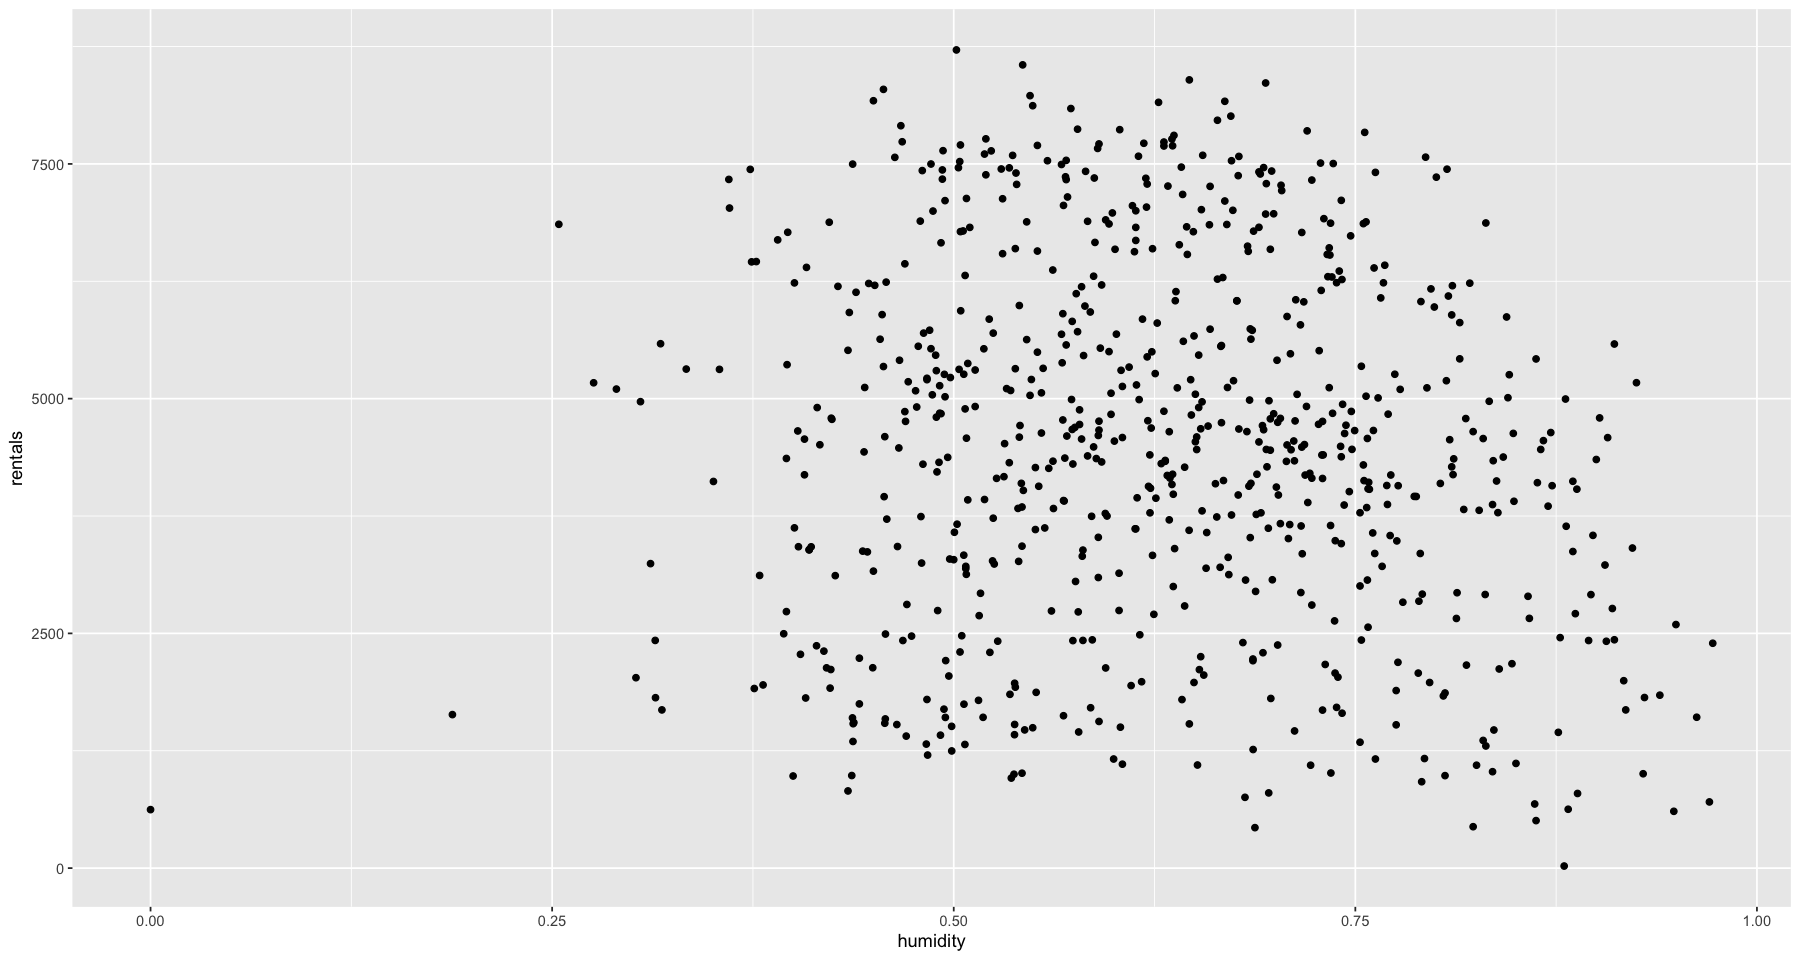

In [7]:
humid <- ggplot(data=rowery, aes(x=humidity, y=rentals)) + geom_point()
wind <-  ggplot(data=rowery, aes(x=windspeed, y=rentals)) + geom_point()
temp <-  ggplot(data=rowery, aes(x=temperature, y=rentals)) + geom_point()

humid

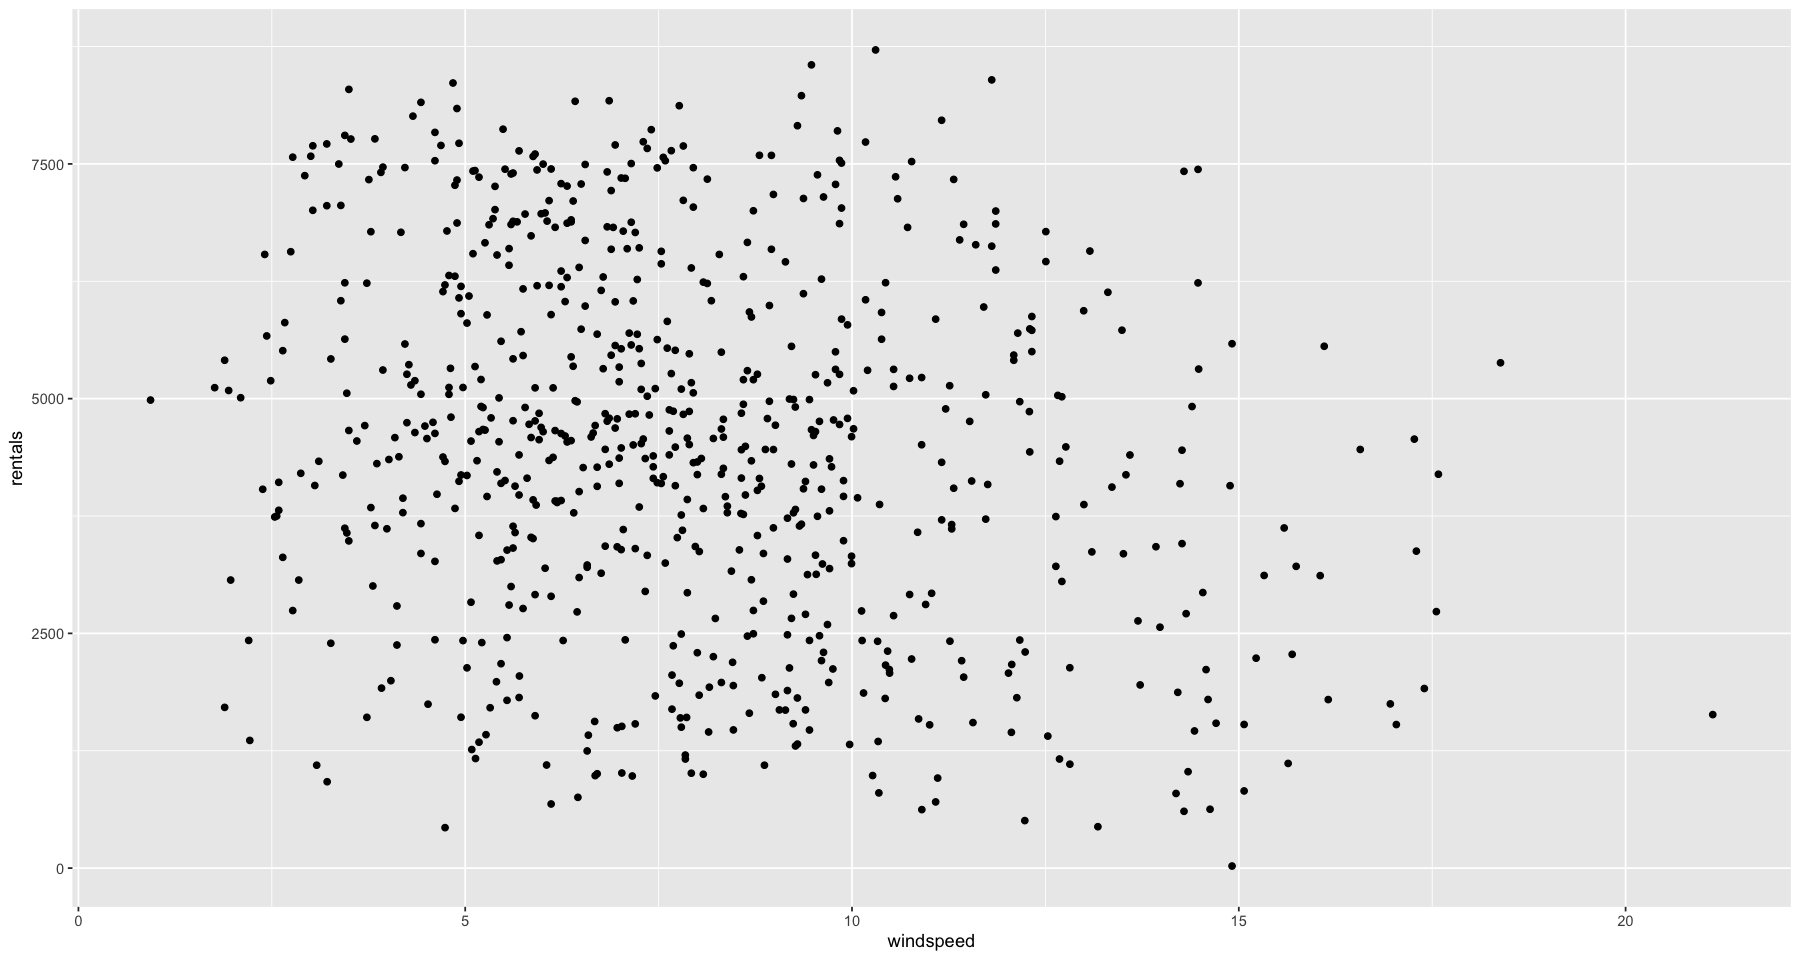

In [8]:
wind

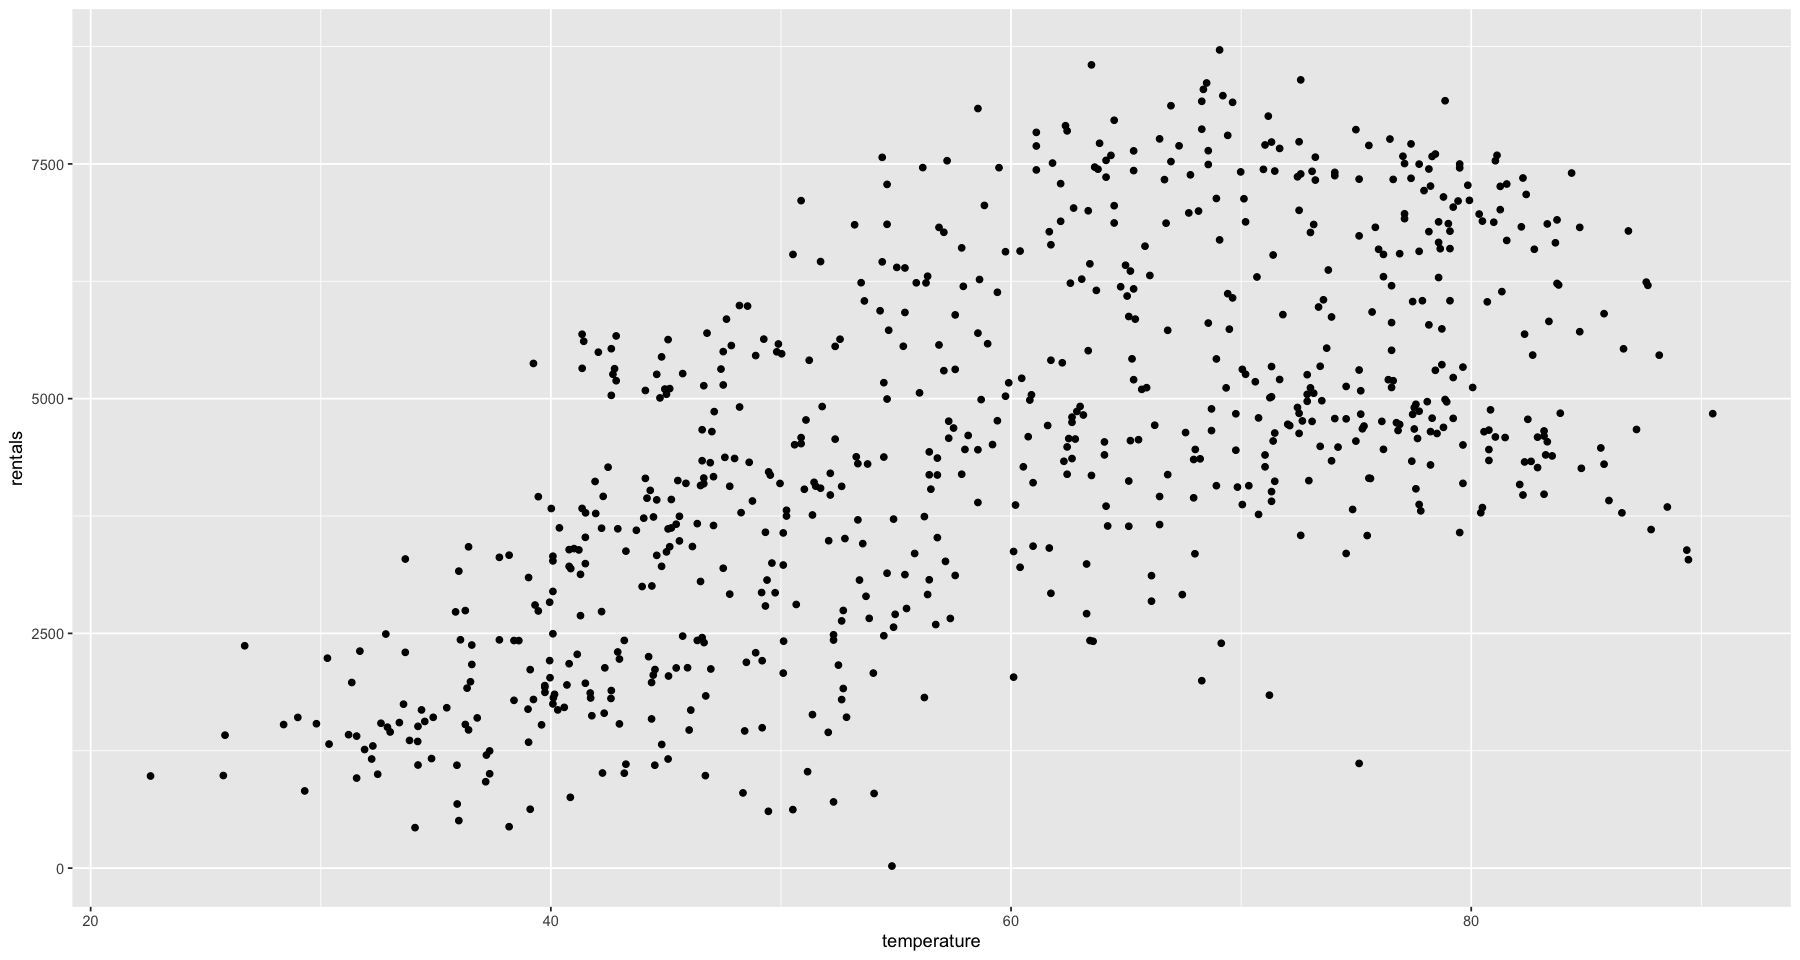

In [9]:
temp

### Korelacja

Oblicz współczynnik korelacji liniowej Pearsona pomiędzy zmiennymi `rentals` i `humidity`.

In [10]:
cov(rowery$rentals, rowery$humidity)

sd(rowery$rentals)
sd(rowery$humidity)

pearson <- cov(rowery$rentals, rowery$humidity) / 
  (sd(rowery$rentals) * sd(rowery$humidity))

pearson

[1] -27.77323

[1] 1937.211

[1] 0.1424291

[1] -0.1006586

Jaki wniosek można wyciągnąć na temat zależności pomiędzy badanymi zmiennymi na podstawie obliczonego współczynnika korelacji Pearsona?

Oblicz współczynnik korelacji Pearsona między zmienną `rentals` a zmiennymi `temperature` oraz `windspeed`, wykorzystując funkcję `cor()`.

In [11]:
cor(rowery$temperature, rowery$rentals)
cor(rowery$windspeed, rowery$rentals)

[1] 0.627494

[1] -0.234545

Na podstawie obliczonych współczynników korelacji odpowiedz na pytania:

- Czy istnieje jakaś zależność między liczbą wypożyczonych rowerów a pozostałymi zmiennymi?

- Jeśli istnieje zależność, to jak silna?

Oblicz tabelę współczynników korelacji dla  dla zmiennych liczbowych ze zbioru `rowery`. Następnie zwizualizuj korelacje za pomocą funkcji `corrplot`.

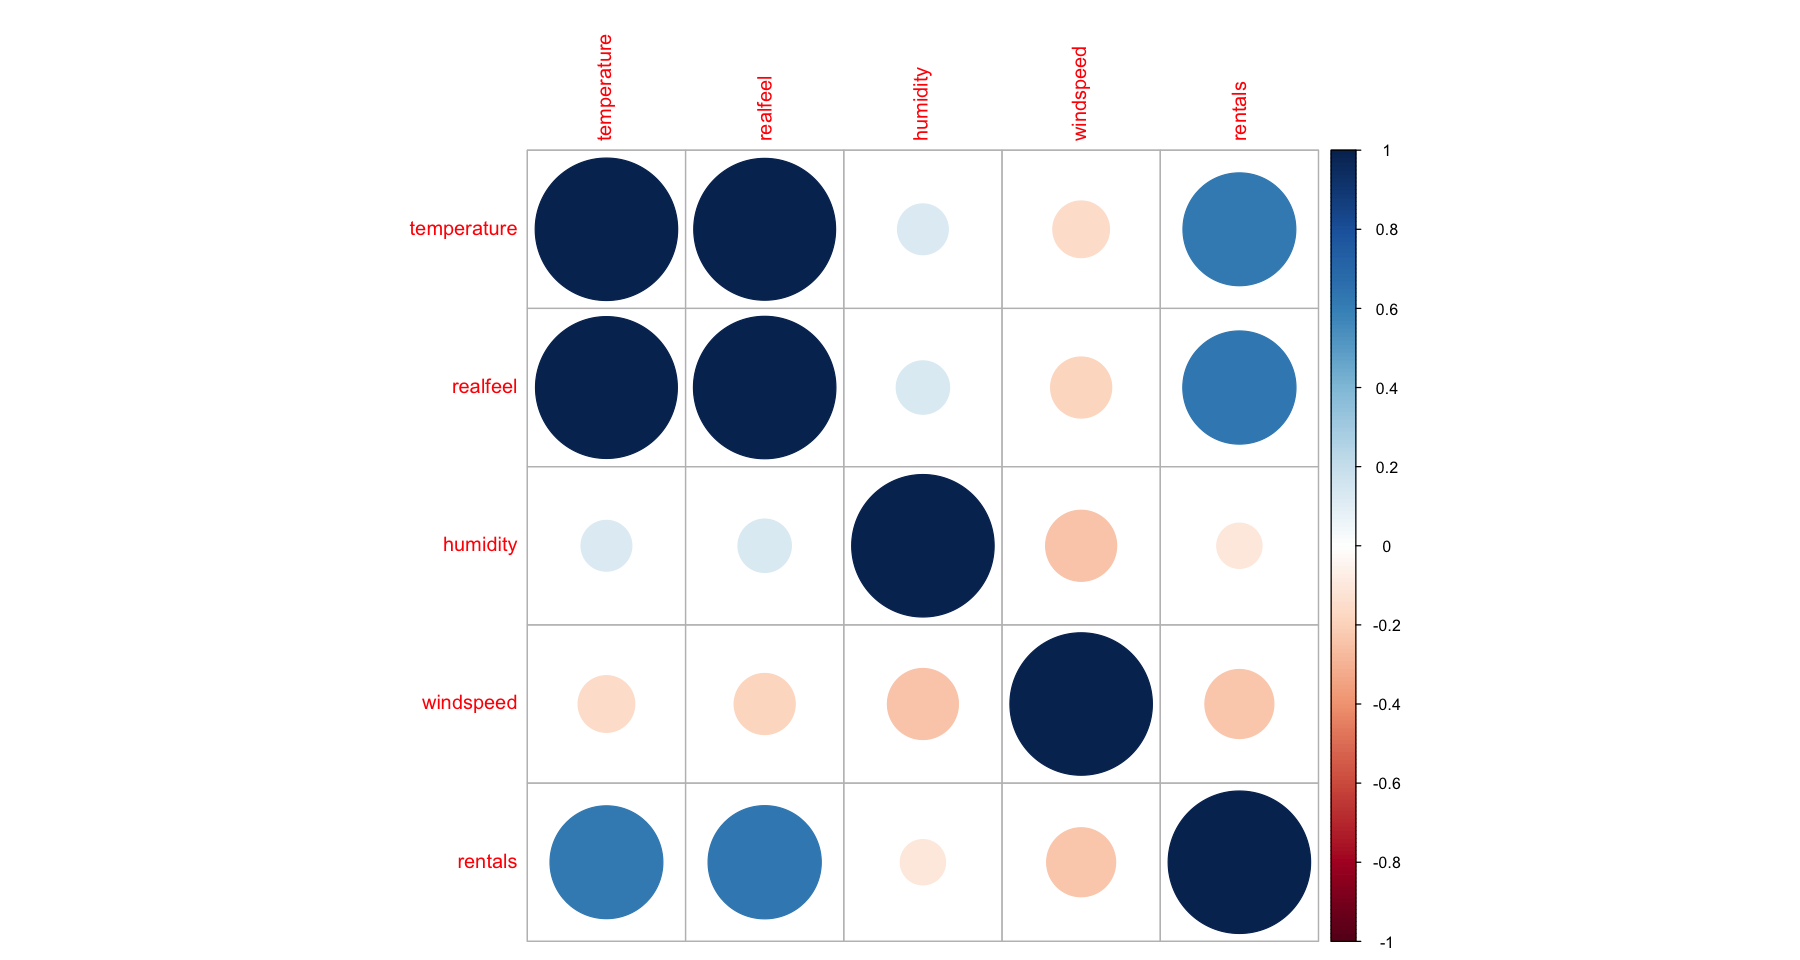

In [12]:
rowery_liczbowe <- rowery %>%
  select(-(date:weather))

rowery_korelacje <- cor(rowery_liczbowe)

library(corrplot)
corrplot(rowery_korelacje)

Ponieważ korelacja między A i B jest taka sama, jak pomiędzy B i A, możemy uprościć wizualizację, pokazując tylko współczynniki nad przekątną - służy do tego argument `type` funkcji `corrplot()`. Ponadto za pomocą argumentu `method` możemy wyświetlić wartości współczynników zamiast kółek.

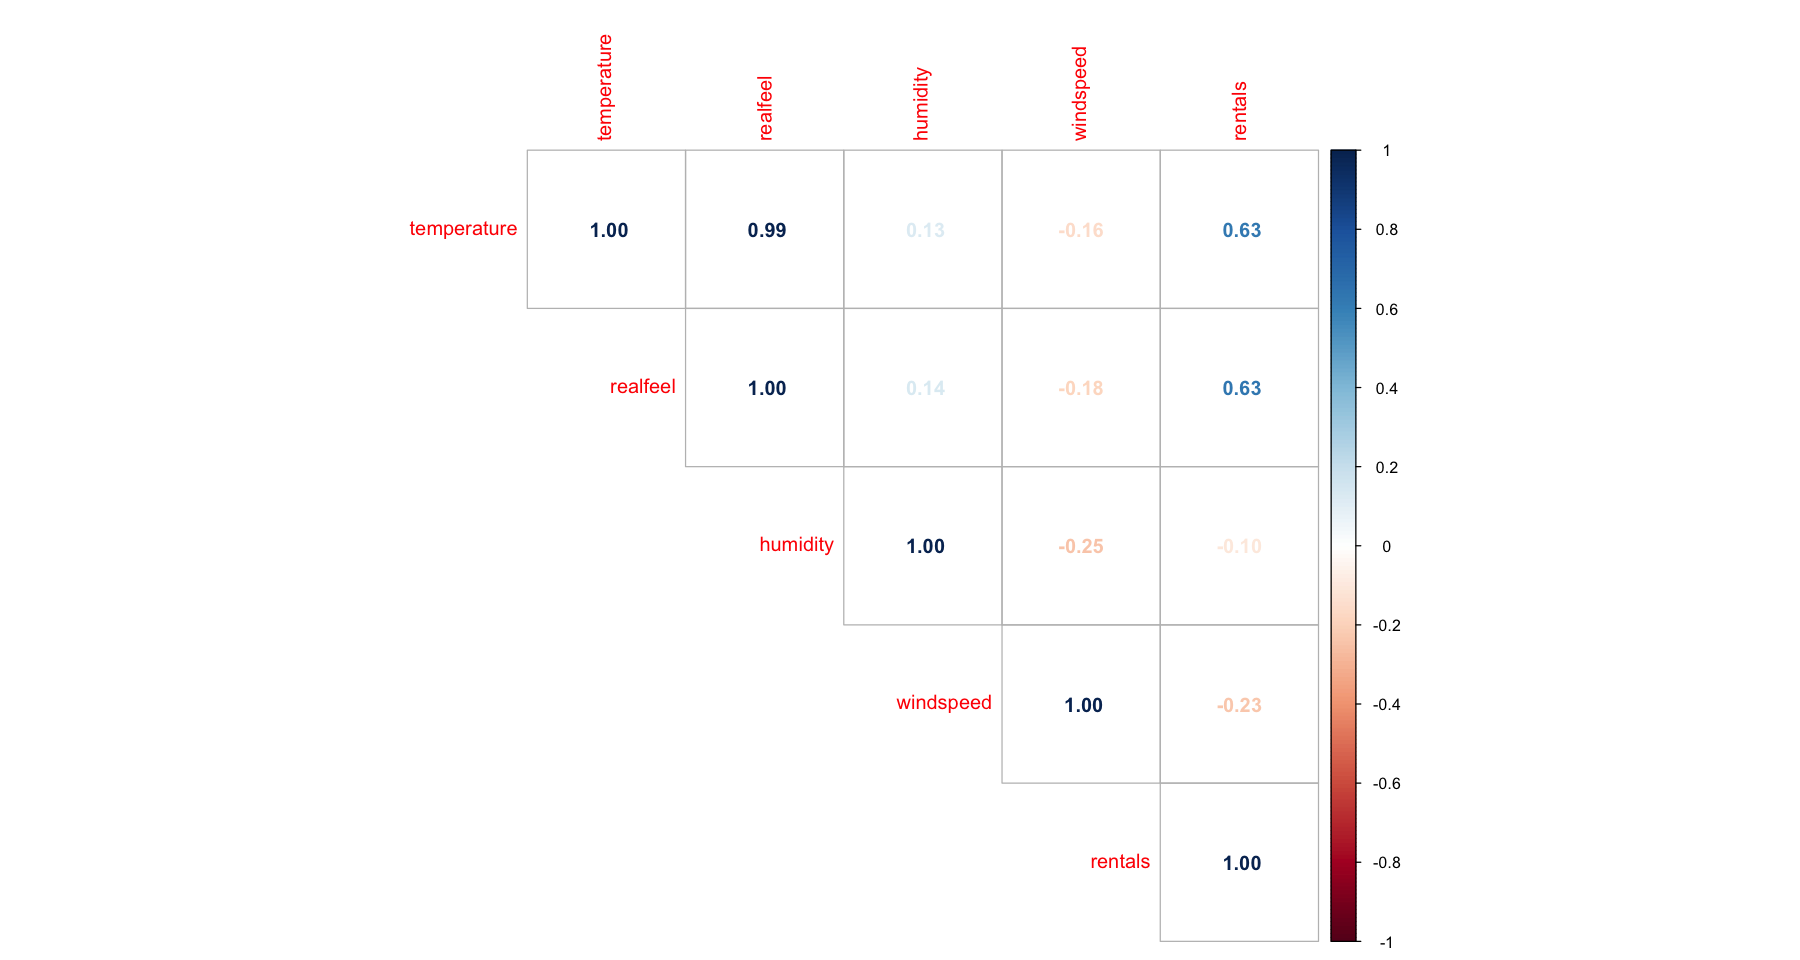

In [13]:
corrplot(rowery_korelacje, type = "upper", method = "number")

### Współczynniki prostej regresji

Ręcznie uzyskaj wartość współczynników `b0` i `b1`.

In [14]:
b1 <- cov(rowery$temperature, rowery$rentals) / var(rowery$temperature)
b1

b0 <- mean(rowery$rentals) - b1 * mean(rowery$temperature)
b0

[1] 78.49539

[1] -166.8767

### Model prostej regresji liniowej

Zbuduj model liniowy dla pary zmiennych `rentals` oraz `temperature`.

In [15]:
rowery_model1 <- lm(data = rowery, rentals~temperature)
rowery_model1


Call:
lm(formula = rentals ~ temperature, data = rowery)

Coefficients:
(Intercept)  temperature  
     -166.9         78.5  


Wyświetl bardziej szczegółowe informacje o modelu za pomocą funkcji `summary()`.

In [16]:
summary(rowery_model1)


Call:
lm(formula = rentals ~ temperature, data = rowery)

Residuals:
    Min      1Q  Median      3Q     Max 
-4615.3 -1134.9  -104.4  1044.3  3737.8 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -166.877    221.816  -0.752    0.452    
temperature   78.495      3.607  21.759   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1509 on 729 degrees of freedom
Multiple R-squared:  0.3937,	Adjusted R-squared:  0.3929 
F-statistic: 473.5 on 1 and 729 DF,  p-value: < 2.2e-16


Co oznaczają statystyki podsumowujące dla reszt (sekcja `Residuals`)?

## 2. Wielokrotna regresja liniowa

Model uzyskany za pomocą pojedynczego predyktora (`temperature`) tłumaczył około 39% zmienności w zbiorze danych.  W kolejnym modelu uwzględnij dodatkowo zmienne `windspeed` oraz `humidity`.

In [17]:
rowery_model2 <- lm(data = rowery, rentals~humidity+windspeed+temperature)

summary(rowery_model2)


Call:
lm(formula = rentals ~ humidity + windspeed + temperature, data = rowery)

Residuals:
    Min      1Q  Median      3Q     Max 
-4780.5 -1082.6   -62.2  1056.5  3653.5 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2706.002    367.483   7.364 4.86e-13 ***
humidity    -3100.123    383.992  -8.073 2.83e-15 ***
windspeed    -115.463     17.028  -6.781 2.48e-11 ***
temperature    78.316      3.464  22.606  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1425 on 727 degrees of freedom
Multiple R-squared:  0.4609,	Adjusted R-squared:  0.4587 
F-statistic: 207.2 on 3 and 727 DF,  p-value: < 2.2e-16


Jak oceniasz nowo powstały model? 

Napisz równanie w jaki sposób `rentals` zależy od wybranych predyktorów.


$$ \text{rentals} = 2706 + \left(-3100\times\text{humidity}\right) + \left(-115\times\text{windspeed}\right) + 78\times\text{temperature} $$

# Ocenianie modelu regresji

Ciąg dalszy ćwiczeń z poprzedniego laboratorium.

## 1. Testy diagnostyczne reszt

Aby model regresji liniowej był prawidłowy, reszty (różnice między wartościami przewidywanymi przez model a rzeczywistymi) muszą spełniać kilka kryteriów:

- ich średnia wynosi zero,

In [18]:
mean(rowery_model2$residuals) # średnia jest bardzo bliska 0, więc kryterium jest spełnione

[1] 1.820778e-13

- mają rozkład normalny,


Attaching package: ‘olsrr’


The following object is masked from ‘package:datasets’:

    rivers




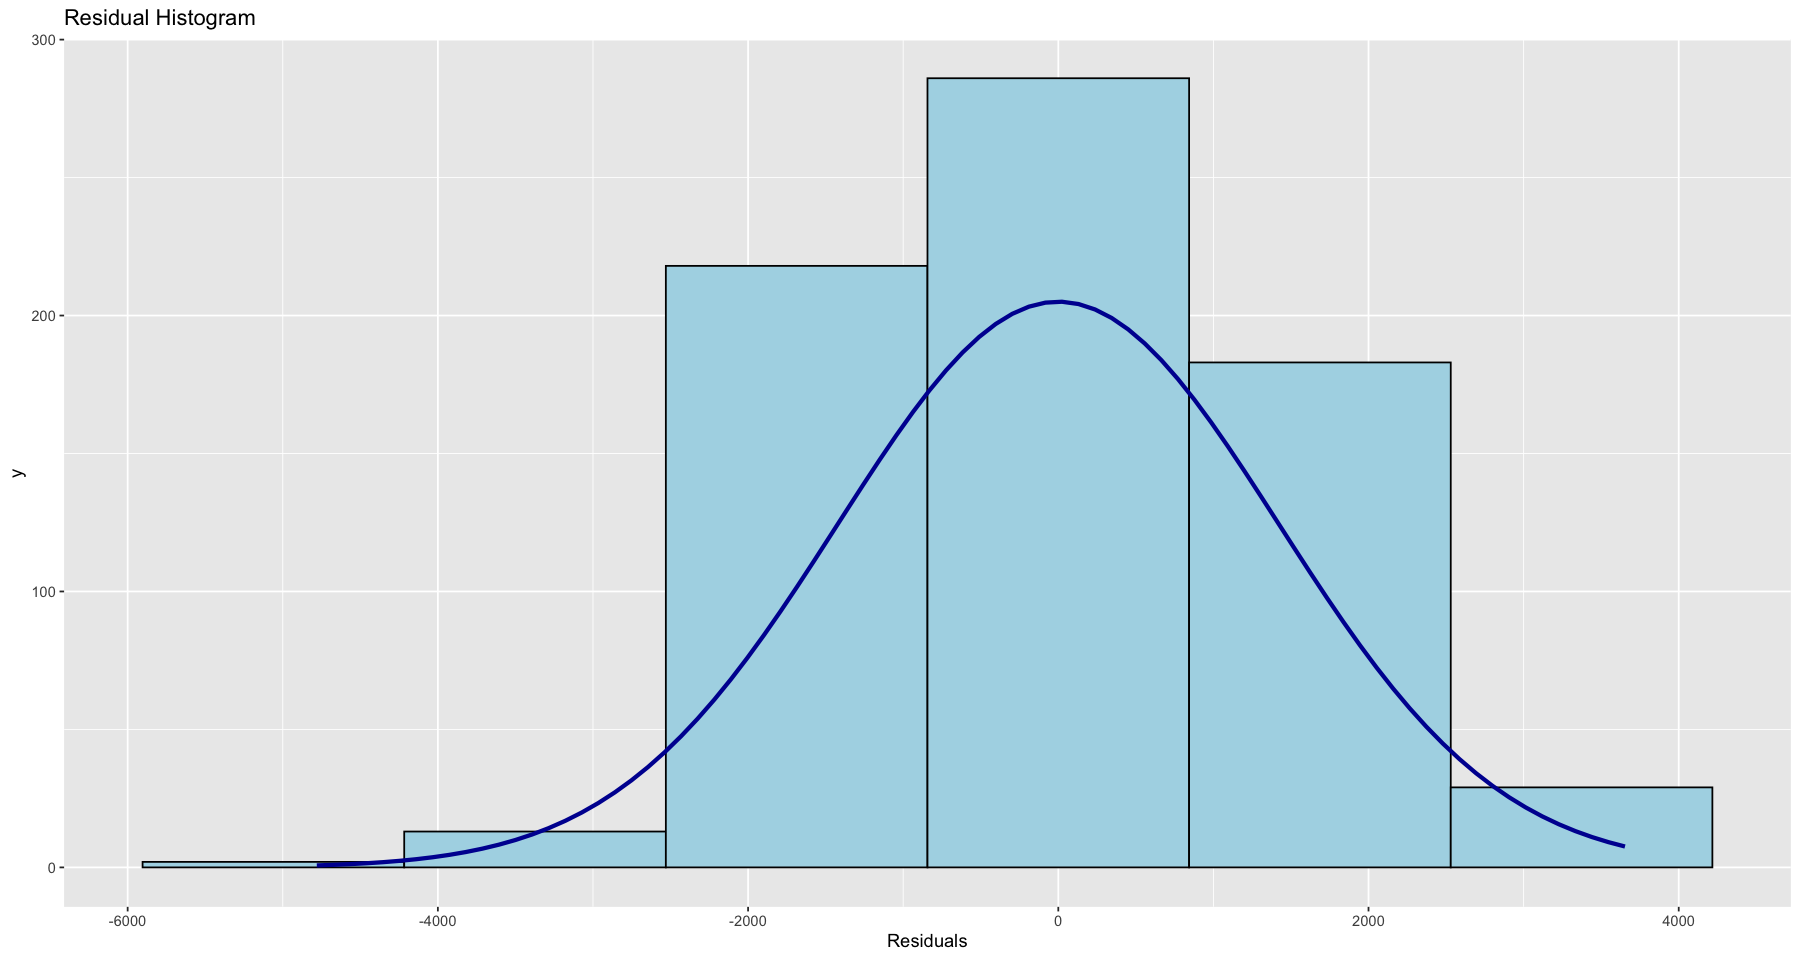

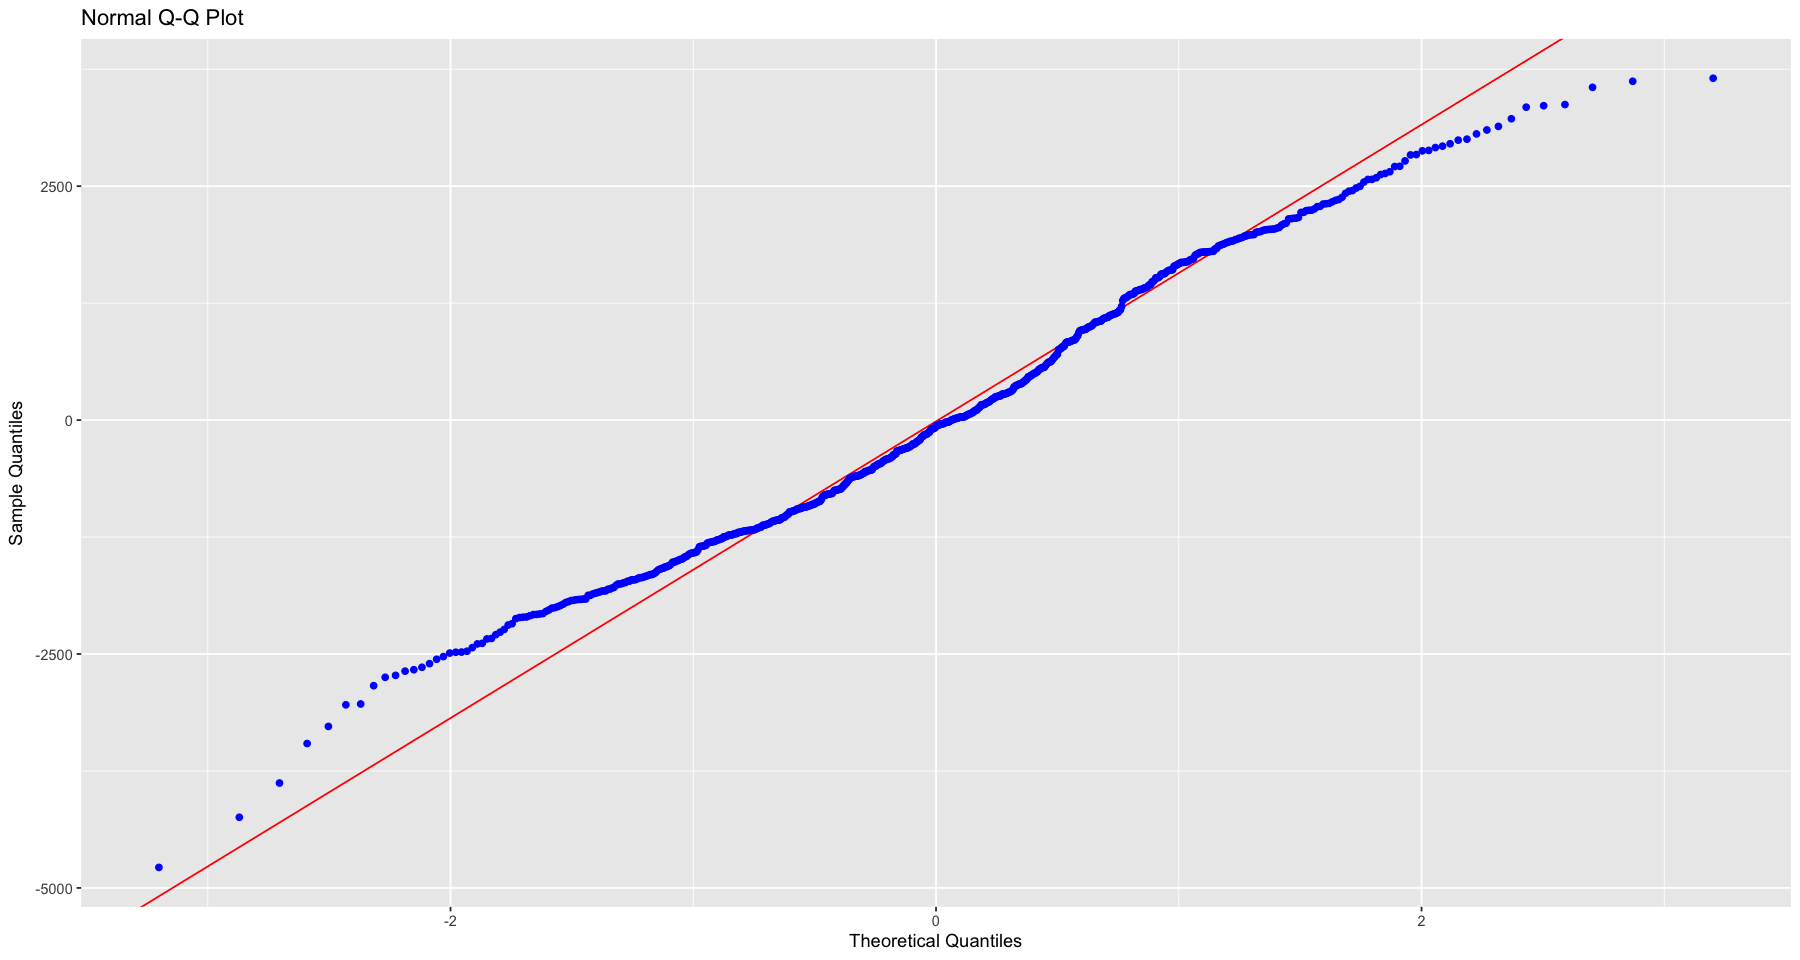

In [19]:
library(olsrr)

ols_plot_resid_hist(rowery_model2)
ols_plot_resid_qq(rowery_model2)

- homoskedastyczność (wartości zmiennej niezależnej mają taką samą wariancję)

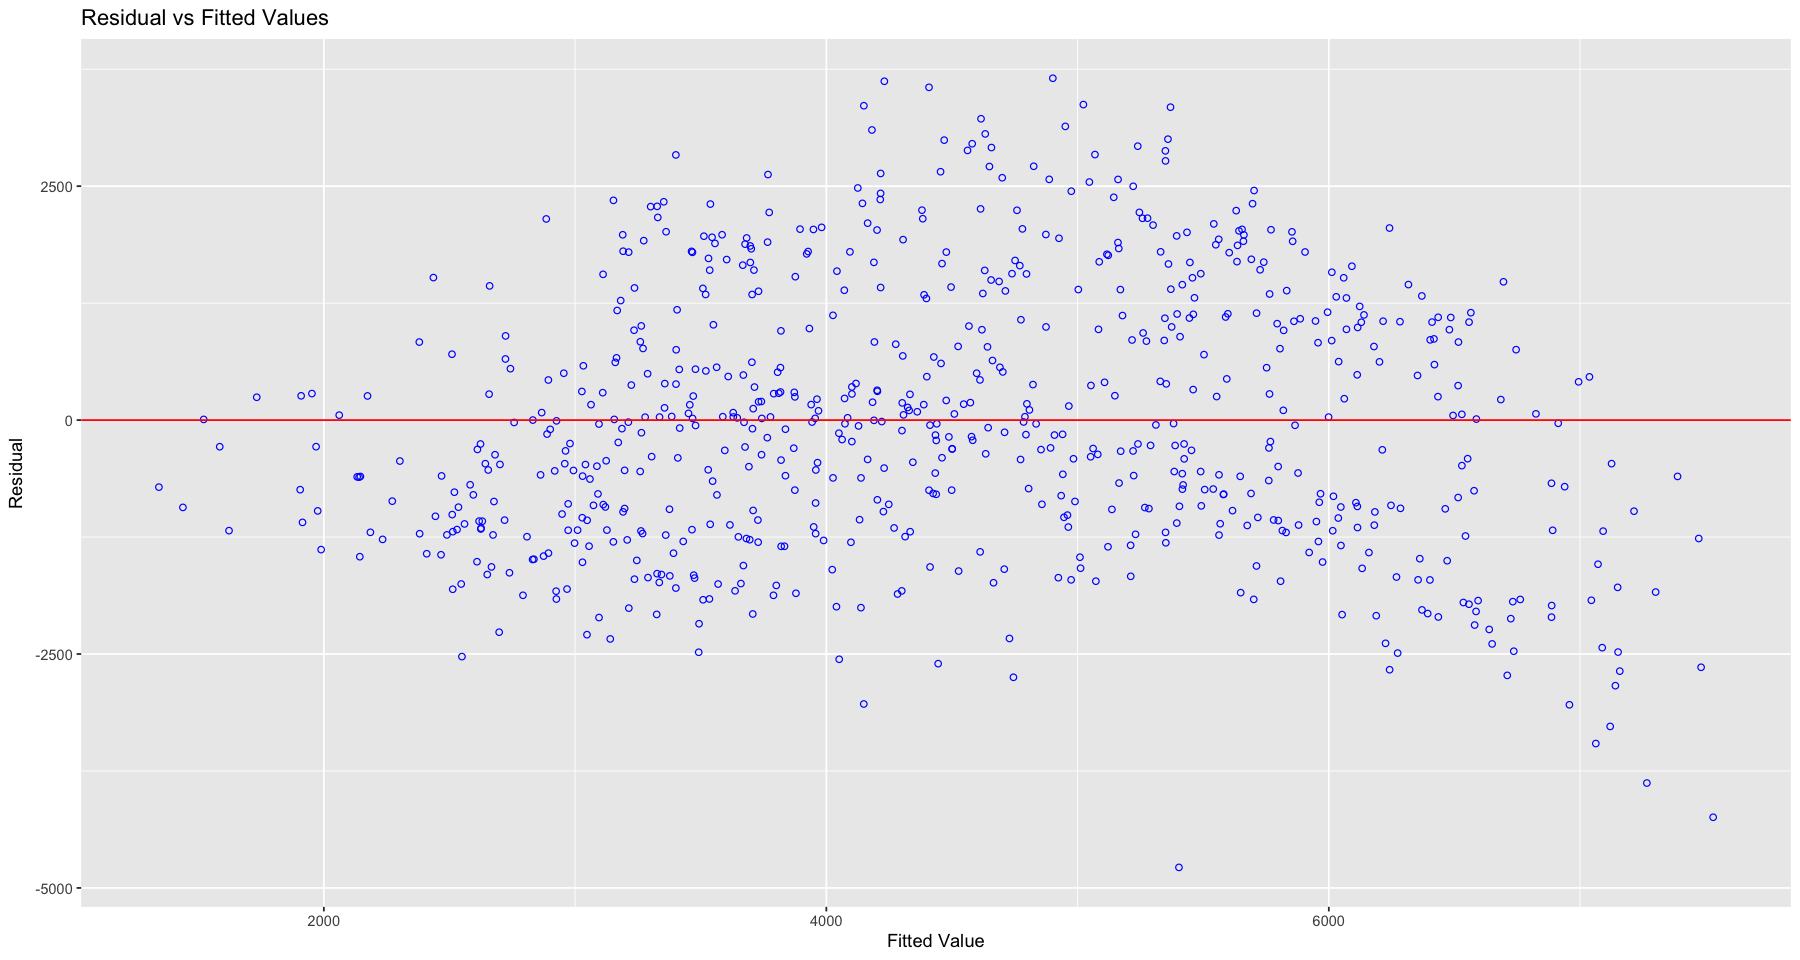

In [20]:
ols_plot_resid_fit(rowery_model2)

- nie są skorelowane

In [21]:
library(car)
# Test Durbina-Watsona
# 0 < DW < 2: dodatnia autokorelacja
# DW = 2: zerowa autokorelacja
# 2 < DW < 4: autokorelacja ujemna

durbinWatsonTest(rowery_model2)

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some




 lag Autocorrelation D-W Statistic p-value
   1       0.7963326     0.4042771       0
 Alternative hypothesis: rho != 0

## 2. Analiza punktów wpływowych

Punkty wpływowe, to skrajne wartości zmiennych predyktorów, które mają znaczący wpływ na model regresji. W przypadku regresji wielokrotnej trudno jest znaleźć wartości odstające, które identyfikują punkty wpływowe. W tym celu stosuje się test statystyczny _odległość Cooka_.

    observation cooks_distance
69   69         0.083466470   
239 239         0.021074076   
204 204         0.020516659   
50   50         0.017264207   
203 203         0.013923865   
668 668         0.012660294   
205 205         0.010164468   
210 210         0.009595062   
554 554         0.007894590   
212 212         0.007714449   
251 251         0.007507810   
250 250         0.007365982   
266 266         0.007179789   
211 211         0.007177980   
160 160         0.007120294   
631 631         0.007088713   
208 208         0.006705139   
530 530         0.006504121   
433 433         0.005979306   
543 543         0.005768543   
45   45         0.005713411   
708 708         0.005688624   
106 106         0.005603058   
341 341         0.005517340   
463 463         0.005486960   

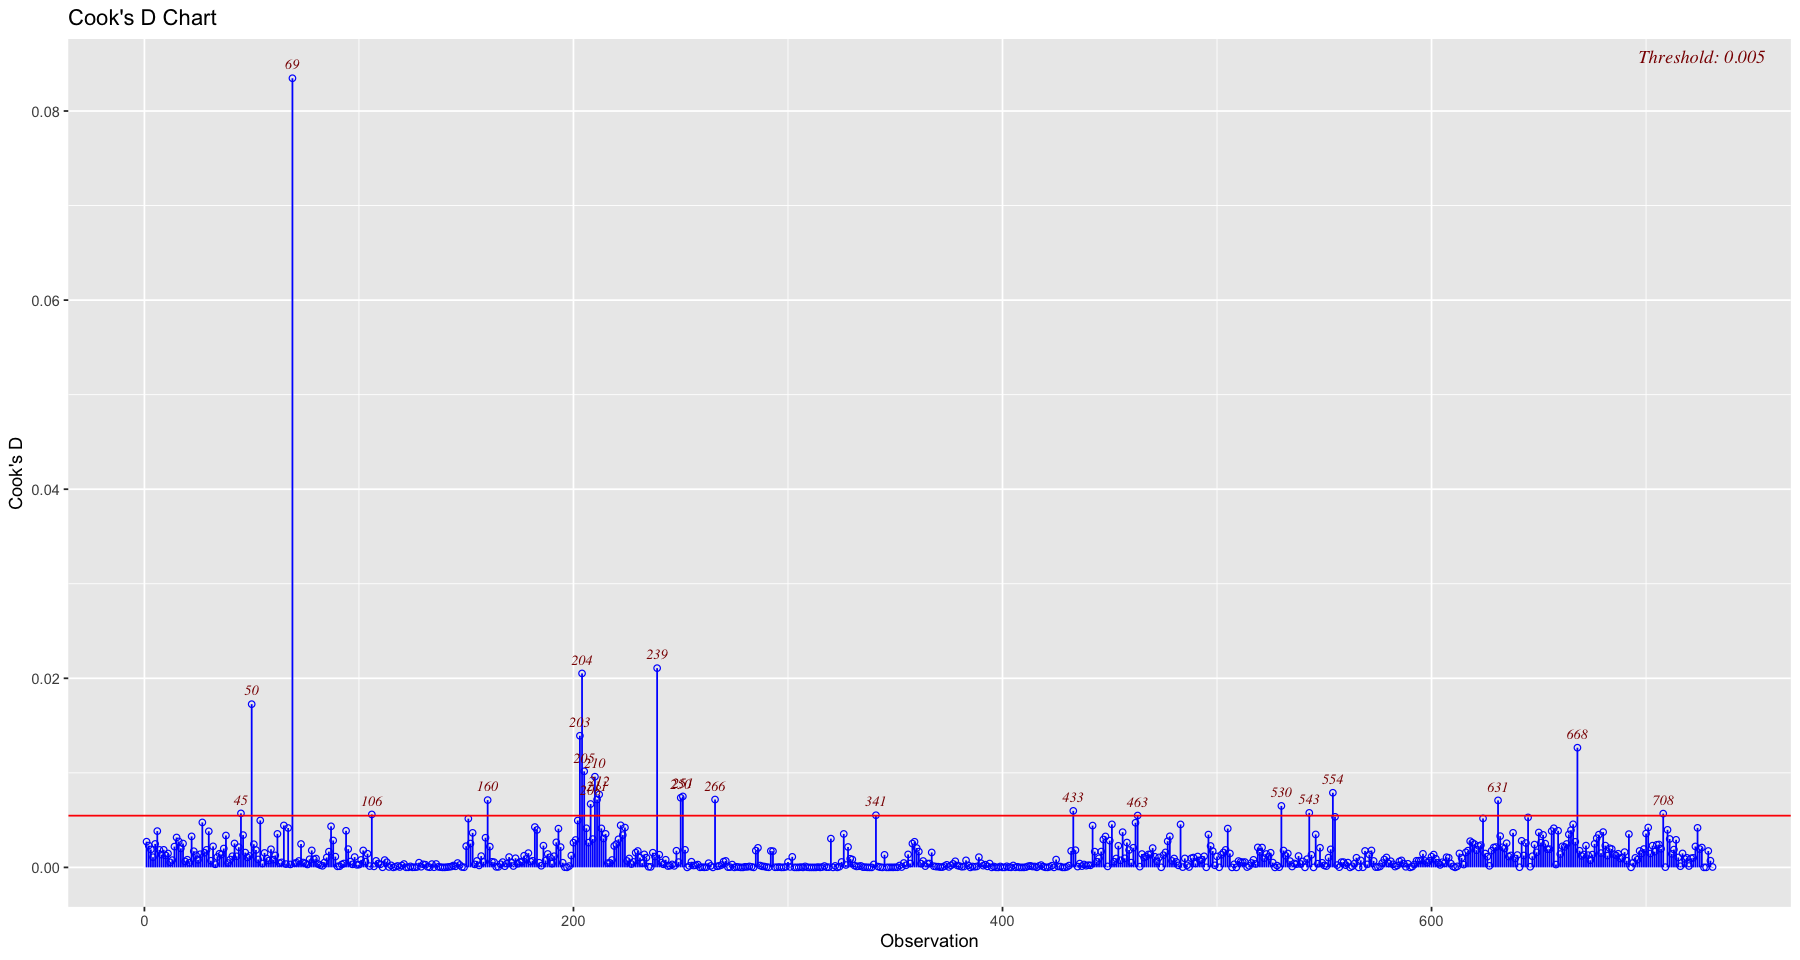

In [22]:
# Wykres odległości Cooka
ols_plot_cooksd_chart(rowery_model2)

# Wyświetlenie wartości odstających według malejącej odległości Cooka
cooks_outliers <- ols_plot_cooksd_chart(rowery_model2, print_plot = FALSE)$outliers
arrange(cooks_outliers, desc(cooks_distance))

### Zadanie: 

1. Porównaj obserwację o najwyższej odległości Cooka z podsumowaniem statystycznym pozostałych danych.
2. Zapisz indeksy 25 zidentyfikowanych punktów wpływowych w zmiennej `outlier_index`.
3. Porównaj podsumowania statystyczne zidentyfikowanych punktów wpływowych z podsumowaniem reszty danych. Jakie obserwujesz różnice?
4. Porównaj rozkład statystyczny oryginalnych danych z rozkładem statystycznym danych bez elementów odstających. Na tej podstawie zdecyduj, czy można usunąć z danych elementy odstające. Jeśli tak - zapisz kopię zbioru danych bez elementów odstających jako `rowery2`.

# Tu wpisz swoje rozwiązanie

## 3. Współliniowość

Zjawisko współliniowości zachodzi wówczas, gdy zmienne predyktorów (dwie lub więcej) są ze sobą mocno skorelowane. W modelach regresji liniowej skutkuje to zawyżonymi błędami standardowymi i utrudnia oddzielenie wpływu poszczególnych predyktorów na odpowiedź.

Do wykrywania współliniowości służy współczynnik inflacji wariancji VIF (ang. _Variance Inflation Factor_). $VIF = \frac{1}{1 - R^2_k = \frac{1}{Tolerance}}$, gdzie $R^2_k$ to współczynnik determinacji $R^2$ równania regresji, gdzie predyktor $k$ znajduje się po lewej stronie, a wszystkie pozostałe zmienne predyktorów po prawej.

Przyjmuje się, że współliniowość istnieje wówczas, gdy $VIF > 5$ ($Tolerance < 0.2$).

Oblicz współczynnik VIF dla zmiennych predyktorów modelu `rowery_model2`.

In [ ]:
ols_vif_tol(rowery_model2)

## 4. Ulepszanie modelu

### Uwzględnienie relacji nieliniowych - regresja wielomianowa

Wykres zależności zmiennej `rentals` od pozostałych predyktorów. Niebieska linia - dopasowanie regresji liniowej, czerwona - dopasowanie po wprowadzeniu predyktorów wielomianowych.

In [ ]:
#library(ggplot2)

#df <- data.frame(x,y)
humid <- ggplot(data=rowery2, aes(x=humidity, y=rentals)) + geom_point() + 
  geom_smooth(method = 'lm', se = TRUE) +
  geom_smooth(method = 'gam', colour = 'red')
wind <-  ggplot(data=rowery2, aes(x=windspeed, y=rentals)) + geom_point() + 
  geom_smooth(method = 'lm', se = TRUE) +
  geom_smooth(method = 'gam', colour = 'red')
temp <-  ggplot(data=rowery2, aes(x=temperature, y=rentals)) + geom_point() + 
  geom_smooth(method = 'lm', se = TRUE) +
  geom_smooth(method = 'gam', colour = 'red')

library(gridExtra)
grid.arrange(humid, wind, temp, nrow=1, ncol=3)

Dodaj do modelu wersje predyktorów podniesionych do kwadratu:

In [ ]:
# Dodanie nowych predyktorów
rowery2 <- rowery2 %>%
  mutate(humidity2 = humidity^2) %>%
  mutate(windspeed2 = windspeed^2) %>%
  mutate(temperature2 = temperature^2)

# Utworzenie nowego modelu liniowego
rowery_model3 <- lm(data = rowery2,
                    rentals ~ humidity + windspeed + temperature +
                      humidity2 + windspeed2 + temperature2)

summary(rowery_model3)

Sprawdź, czy wszystkie predyktory są istotne. Jeśli nie - popraw model usuwając zmienne nieistotne. Porównaj dane diagnostyczne nowego modelu z danymi modelu poprzedniego. Co się zmieniło?

### Uwzględnienie zmiennych kategorialnych

Za pomocą funkcji `summary()` wyświetl podsumowanie dla zmiennych czynnikowych `season`, `holiday`, `weekday` oraz `weather`.

Zamień wartości liczbowe reprezentujące wartości kategorialne na opisowe. Służy do tego funkcja `revalue()` z pakiety `plyr`.

In [ ]:
rowery2 <- rowery2 %>%
  mutate(season = plyr::revalue(season, c("1" = "Zima", "2" = "Wiosna",
                                    "3" = "Lato", "4" = "Jesien"))) %>%
  mutate(holiday = plyr::revalue(holiday, c("0" = "Nie", "1" = "Tak"))) %>%
  mutate(weekday = plyr::revalue(weekday, c("0" = "Niedziela","1" = "Poniedzialek", 
                                      "2" = "Wtorek", "3" = "Sroda", "4" = "Czwartek",
                                      "5" = "Piatek", "6" = "Sobota"))) %>%
  mutate(weather = plyr::revalue(weather, c("1" = "Ladna pogoda", "2" = "Lekkie opady",
                                      "3" = "Obfite opady")))

Utwórz kolejny model, uwzględniający wybraną zmienną kategorialną. Przeanalizuj podsumowanie modelu.

### Interakcje między zmiennymi

Zdarza się, że dwie zmienne mają łączny wpływ na odpowiedź. Na przykład interakcje mogą zachodzić między zmiennymi `weather` oraz `windspeed` lub między zmiennymi `weather` a `temperature`. Efekt interakcji można uwzględnić w modelu regresji przy użyciu operatora `*`. 

Utwórz nowy model regresji, uwzględniający interakcję `weather * windspeed`.

### Wybieranie ważnych zmiennych

W zbiorze danych `rowery2` dodaj trzy predyktory oparte na zmiennej `date`: 

- `dzien` - liczba dni, jakie upłynęły od dnia rozpoczęcia programu (różnica między zmienną `date` a minimalną wartością zmiennej `date`)

- `miesiac`

- `rok`.

In [ ]:
library(lubridate)

rowery2 <- rowery2 %>%
  mutate(dzien = as.numeric(date - min(date))) %>%
  mutate(miesiac = as.factor(month(date))) %>%
  mutate(rok = as.factor(year(date))) %>%
  select(-date)

Zastosuj funkcję `ols_step_both_p()` do selekcji zmiennych:

In [ ]:
ols_step_both_p(
  model = lm(
    data = rowery2,
    rentals ~ humidity + weekday + holiday + 
      temperature + humidity2 + temperature2 + season +
      windspeed * weather + realfeel + dzien + miesiac + rok
  ),
  pent = 0.2, # wartość progowa p zmiennych uwzględnianych w modelu
  prem = 0.01, # progowa wartość p zmiennych usuwanych z modelu
  details = FALSE # flaga wskazująca jak dużo informacji wyświetlać
)

Utwórz nowy model, wykorzystując zmienne wybrane podczas selekcji. Następnie ponownie sprawdź homoskedastyczność modelu.

# Tu wpisz swoje rozwiązanie